In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from collections import OrderedDict
from itertools import compress
import scipy.stats

In [2]:
# Read in time course from minireader for each plate. Alpha/Bravo/Charlie/Delta indicates the name of the
# specific minireader used, and plate 1-4 corresponds to the 4 96-well plates.
plate1 = pd.read_excel('../data/validation/platefile_20171215.xls',sheetname='RES0_od')

# Read the plate layout file. All plates have identical layouts.
# The plate layout file also includes endpoint OD600 for all 4 plates as measured by the Tecan.
plate_layout = pd.read_csv('../data/validation/plate_layout_20171215.csv',sep='\t')


In [3]:
# discard reads before temp stabilization
plate1 = plate1.iloc[24:,]

# replace timestamp with time in minutes (reads are taken every 5 minutes)
plate1['Time (m)'] = (plate1.index - plate1.index[0])*5


In [4]:
species = ['356','361']
for specie in species:
            plate_layout[specie] = plate_layout['species'].str.contains(specie)

plate_layout_copy = plate_layout[['well','tecan_OD']]
plate_layout_copy.index = plate_layout_copy['well']
plate_layout_copy.drop(labels='well',inplace=True,axis=1)

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


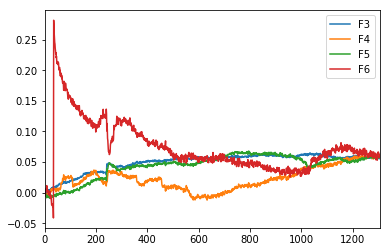

In [5]:
# Determine blank value to substract from final tecan reading for each plate.
# Get average of the 4 blanks for each plate.
blanks = plate_layout[plate_layout['species'] == 'Blank']['tecan_OD']
blank_mean = blanks.mean()

od_only = plate1.drop(labels=['UNIX Timestamp','Temperature (deg. C)','Time (m)'],axis=1)


# Get the initial and final OD reading from all wells in minireader
p1_endpoints = od_only.tail(1)

p1_initials = od_only.head(1) * 0
# Assume the initial OD reading from the tecan would have been 0.

# subtract the initial minireader points from the reading.
od_only = pd.DataFrame(od_only.values - p1_initials.values,columns=od_only.columns)

# get tecan endpoints
plate_layout_copy = plate_layout[['well','tecan_OD']]
plate_layout_copy.index = plate_layout_copy['well']
plate_layout_copy.drop(labels='well',inplace=True,axis=1)
tecan_endpoints = plate_layout_copy.transpose().loc['tecan_OD']

# subtract by the blank means
tecan_endpoints_zerod = pd.DataFrame(tecan_endpoints) - blank_mean
# normalize by multiplying by the ratio of tecan od to minireader od at the last timepoint
p1_normalized = pd.DataFrame(np.multiply(od_only.values,(np.divide(tecan_endpoints_zerod.values,p1_endpoints.transpose().values)).transpose()),columns=od_only.columns)

p1_normalized[['F3','F4','F5','F6']].plot()

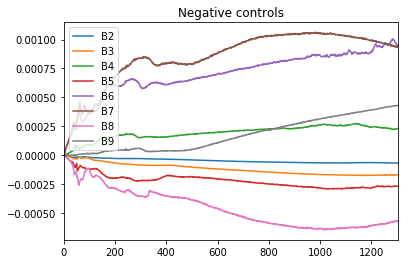

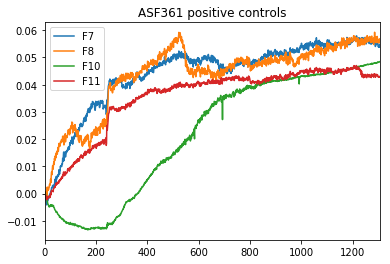

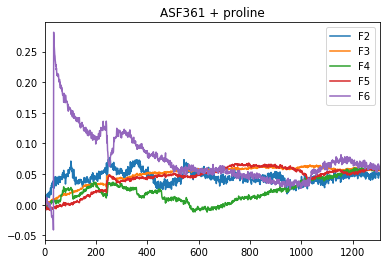

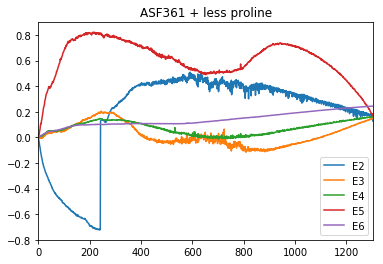

In [6]:
# plot some conditions
p1_normalized[['B2','B3','B4','B5','B6','B7','B8','B9']].plot(title='Negative controls')
p1_normalized[['F7','F8','F10','F11']].plot(title='ASF361 positive controls')
p1_normalized[['F2','F3','F4','F5','F6']].plot(title='ASF361 + proline')
p1_normalized[['E2','E3','E4','E5','E6']].plot(title='ASF361 + less proline')

In [7]:
# define a multiple testing correction function for endpoint testing
def p_adjust_bh(p):
    """Benjamini-Hochberg p-value correction for multiple hypothesis testing."""
    p = np.asfarray(p)
    by_descend = p.argsort()[::-1]
    by_orig = by_descend.argsort()
    steps = float(len(p)) / np.arange(len(p), 0, -1)
    q = np.minimum(1, np.minimum.accumulate(steps * p[by_descend]))
    return q[by_orig]

0.0 0.0808555983701
6.0 0.66252058354
1.0 0.190430263826
2.0 0.382733088885
0.0 0.0808555983701
4.0 1.0
0.0 0.0808555983701
2.0 0.382733088885


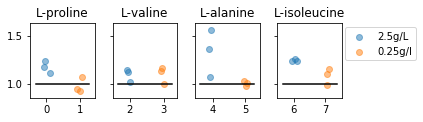

In [8]:
# plot and test endpoint abundance differences fro ASF356
only_356 = plate_layout.loc[plate_layout['species'] == '356']
# get the positive control density
mean356_pos_control = only_356.loc[only_356['media'] == 'S9']['tecan_OD'].mean()
# remove the positive control for plotting
plotframe = only_356.loc[only_356['media'] != 'S9']

groups = plotframe.groupby('media')
fig, ax = plt.subplots(1,4,sharey=True,figsize=(5,1.8))
#ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
groupcount = 0
panelcount = 0
margin = 0.1
lines = []
labels = []
titles = ['L-proline','L-valine','L-alanine','L-isoleucine']
pvals = []
for name, group in groups:
    
    x = [groupcount]*3
    # add jitter
    x = x + np.random.normal(loc=0.0,scale=0.07,size=3)
    y = group['tecan_OD']
    # calculate mann-whitney u-test p value
    (stat,p) = scipy.stats.mannwhitneyu(only_356.loc[only_356['media'] == 'S9']['tecan_OD'],y,alternative="two-sided")
    #(stat,p) = scipy.stats.ttest_ind(only_356.loc[only_356['media'] == 'S9']['tecan_OD'],y)
    pvals.append(p)
    print(stat,p)
    # normalize to percentage for plotting
    y = group['tecan_OD']/mean356_pos_control
    line = ax[panelcount].scatter(x=x,y=y, marker='o',alpha=0.5, label=name)
    lines.append(line)
    groupcount+=1
    if groupcount % 2 == 0:
        ax[panelcount].margins(margin)
        ax[panelcount].plot((ax[panelcount].get_xlim()[0]-margin,ax[panelcount].get_xlim()[1]+margin),(1.0,1.0),color='black')
        ax[panelcount].set_title(titles[panelcount])
        panelcount+=1
plt.legend(lines,['2.5g/L','0.25g/l'],loc=(1.05,0.5))
fig.subplots_adjust(right=1.6)
plt.tight_layout()

In [9]:
p_adjust_bh(pvals)

array([ 0.21561493,  0.75716638,  0.38086053,  0.51031079,  0.21561493,
        1.        ,  0.21561493,  0.51031079])

4.0 0.0946929425995
7.0 0.296269871484


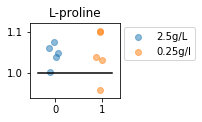

In [10]:
# Do the same for ASF361
only_361 = plate_layout.loc[plate_layout['species'] == '361']
# get the positive control density
mean361_pos_control = only_361.loc[only_361['media'] == 'S9']['tecan_OD'].mean()
# remove the positive control for plotting
plotframe = only_361.loc[only_361['media'] != 'S9']

groups = plotframe.groupby('media')
fig, ax = plt.subplots(1,1,sharey=True,figsize=(2,1.8))
#ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
groupcount = 0
panelcount = 0
margin = 0.1
lines = []
labels = []
titles = ['L-proline']
pvals = []
for name, group in groups:
    
    x = [groupcount]*5
    # add jitter
    x = x + np.random.normal(loc=0.0,scale=0.07,size=5)
    y = group['tecan_OD']
    # calculate mann-whitney u-test p value
    (stat,p) = scipy.stats.mannwhitneyu(only_361.loc[only_361['media'] == 'S9']['tecan_OD'],y,alternative="two-sided")
    #(stat,p) = scipy.stats.ttest_ind(only_356.loc[only_356['media'] == 'S9']['tecan_OD'],y)
    pvals.append(p)
    print(stat,p)
    # normalize to percentage for plotting
    y = group['tecan_OD']/mean361_pos_control
    line = ax.scatter(x=x,y=y, marker='o',alpha=0.5, label=name)
    lines.append(line)
    groupcount+=1
    if groupcount % 2 == 0:
        ax.margins(margin)
        ax.plot((ax.get_xlim()[0]-margin,ax.get_xlim()[1]+margin),(1.0,1.0),color='black')
        ax.set_title(titles[panelcount])
        panelcount+=1
plt.legend(lines,['2.5g/L','0.25g/l'],loc=(1.05,0.5))
fig.subplots_adjust(right=1.6)
plt.tight_layout()

In [11]:
p_adjust_bh(pvals)

array([ 0.18938589,  0.29626987])

In [12]:
plate_layout.loc[(plate_layout['356'] == True) & ((plate_layout['media'] == 'S1') | \
                                                  (plate_layout['media'] == 'S2') | \
                                                  (plate_layout['media'] == 'S9'))]['well']

25     C2
26     C3
33    C10
37     D2
38     D3
45    D10
49     E2
50     E3
57    E10
Name: well, dtype: object

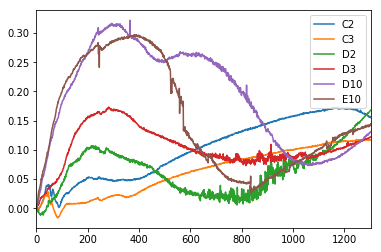

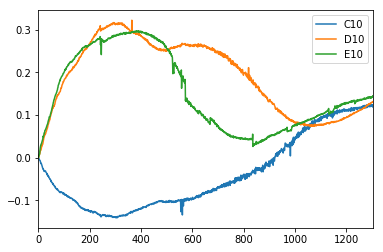

In [13]:
plotlist = plate_layout.loc[(plate_layout['356'] == True) & ((plate_layout['media'] == 'S2') | \
                                                  (plate_layout['media'] == 'S1') | \
                                                  (plate_layout['media'] == 'S9'))]['well']
control356 = plate_layout.loc[(plate_layout['356'] == True) & 
                                                  (plate_layout['media'] == 'S9')]['well']
# remove bad wells
plotlist = plotlist[plotlist != 'E2']
plotlist = plotlist[plotlist != 'C10']
plotlist = plotlist[plotlist != 'E3']
plotlist = plotlist[plotlist != 'E5']
p1_normalized[plotlist].plot()
p1_normalized[control356].plot()